In [1]:
#@markdown ### **Imports**

from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision
import collections
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from diffusers.schedulers.scheduling_dpmsolver_multistep import DPMSolverMultistepScheduler
from diffusers.schedulers.scheduling_euler_discrete import EulerDiscreteScheduler
from diffusers.schedulers.scheduling_edm_euler import EDMEulerScheduler
from diffusers.training_utils import EMAModel, compute_snr
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
import pickle
from skimage.metrics import structural_similarity as compare_ssim

# env import
import cv2
import skimage.transform as st
import os
import time
import random

import matplotlib.pyplot as plt
import diffusers
import open3d as o3d
import trimesh

from utils import *


/home/rpklab/anaconda3/envs/dp/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#@markdown ### **Network**
#@markdown
#@markdown Defines a 1D UNet architecture `ConditionalUnet2D`
#@markdown as the noies prediction network
#@markdown
#@markdown Components
#@markdown - `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
#@markdown - `Downsample2d` Strided convolution to reduce temporal resolution
#@markdown - `Upsample2d` Transposed convolution to increase temporal resolution
#@markdown - `Conv2dBlock` Conv2d --> GroupNorm --> Mish
#@markdown - `ConditionalResidualBlock2D` Takes two inputs `x` and `cond`. \
#@markdown `x` is passed through 2 `Conv2dBlock` stacked together with residual connection.
#@markdown `cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        '''
        encode the time step, x is the time step. 
        '''
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Downsample2d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Upsample2d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose2d(dim, dim, 4, 2, 1)
#         self.conv = nn.ConvTranspose2d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv2dBlock(nn.Module):
    '''
        Conv2d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2), # conv with padding
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock2D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8):
        super().__init__()
        
        self.blocks = nn.ModuleList([
            Conv2dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv2dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        # add conditional to the Unet
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        # print('x size is', x.size())
        out = self.blocks[0](x)
#         print('cond size is: ', cond.size())
        embed = self.cond_encoder(cond)
#         print('embed size is: ', embed.size())
        embed = embed.reshape(embed.shape[0], 2, self.out_channels, 1)
        embed = embed.unsqueeze(-1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias
#         print('scale size is: ', scale.size())
        
        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet2D(nn.Module):
    def __init__(self,
        input_channel,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims= [32, 64, 128], #[128, 256, 512], #[256, 512, 1024], # #[32, 64, 256, 256],
        kernel_size=5,
        n_groups=8
        ):
        """
        input_channel: channel of the input. 
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_channel] + list(down_dims)
        start_dim = down_dims[0]
        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim
        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock2D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock2D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock2D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock2D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Downsample2d(dim_out) if not is_last else nn.Identity()
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock2D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock2D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Upsample2d(dim_in) if not is_last else nn.Identity()
            ]))

        final_conv = nn.Sequential(
            Conv2dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv2d(start_dim, input_channel, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: torch.Tensor,
            timestep: Union[torch.Tensor, float, int],
            global_cond=None):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
#         # (B,T,C)
#         sample = sample.moveaxis(-1,-2)
#         # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)
#         print(global_feature.size())
        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)
#         print('sample size is: ', sample.size())
        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
#             print('x size is: ', x.size())
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            y = h.pop()
            # print('size of x is: ', x.size())
            # print('size of y is: ', y.size())
            x = torch.cat((x, y), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            
#             print('x before upsample is: ', x.size())
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
#         x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x


In [3]:
#@markdown ### **Vision Encoder**
#@markdown
#@markdown Defines helper functions:
#@markdown - `get_resnet` to initialize standard ResNet vision encoder
#@markdown - `replace_bn_with_gn` to replace all BatchNorm layers with GroupNorm

def get_resnet(name:str, weights=None, **kwargs) -> nn.Module:
    """
    name: resnet18, resnet34, resnet50
    weights: "IMAGENET1K_V1", None
    """
    # Use standard ResNet implementation from torchvision
    func = getattr(torchvision.models, name)
    resnet = func(weights=weights, **kwargs)

    # remove the final fully connected layer
    # for resnet18, let the output dim be 256
    resnet.fc = nn.Linear(512, 256) #torch.nn.Identity()
    return resnet


def replace_submodules(
        root_module: nn.Module,
        predicate: Callable[[nn.Module], bool],
        func: Callable[[nn.Module], nn.Module]) -> nn.Module:
    """
    Replace all submodules selected by the predicate with
    the output of func.

    predicate: Return true if the module is to be replaced.
    func: Return new module to use.
    """
    if predicate(root_module):
        return func(root_module)

    bn_list = [k.split('.') for k, m
        in root_module.named_modules(remove_duplicate=True)
        if predicate(m)]
    for *parent, k in bn_list:
        parent_module = root_module
        if len(parent) > 0:
            parent_module = root_module.get_submodule('.'.join(parent))
        if isinstance(parent_module, nn.Sequential):
            src_module = parent_module[int(k)]
        else:
            src_module = getattr(parent_module, k)
        tgt_module = func(src_module)
        if isinstance(parent_module, nn.Sequential):
            parent_module[int(k)] = tgt_module
        else:
            setattr(parent_module, k, tgt_module)
    # verify that all modules are replaced
    bn_list = [k.split('.') for k, m
        in root_module.named_modules(remove_duplicate=True)
        if predicate(m)]
    assert len(bn_list) == 0
    return root_module        


def replace_bn_with_gn(
    root_module: nn.Module,
    features_per_group: int=16) -> nn.Module:
    """
    Relace all BatchNorm layers with GroupNorm.
    """
    replace_submodules(
        root_module=root_module,
        predicate=lambda x: isinstance(x, nn.BatchNorm2d),
        func=lambda x: nn.GroupNorm(
            num_groups=x.num_features//features_per_group,
            num_channels=x.num_features)
    )
    return root_module

In [4]:
class Experiment(): 
    # model_path is the path of the diffusion model
    # ori_path is the path that saves the information of the original state of the garment

    def __init__(self, model_path, ori_path): 
        # load pretrained model: 
        self.model = torch.load(model_path)
        self.model.eval()
        # save one flat state_dict.npy in ori_path/
        self.ori_info = np.load(ori_path, allow_pickle='TRUE').item() 
        orig_pts = np.array(self.ori_info['pts'][0])
        self.orig_pts, _, _ = process_pts(orig_pts)
        # use GPU to accelerate computation
        self.device = torch.device('cuda')

    def run_Diffusion_single(self, obs_depth_test, img_w, img_h, num_iter = 10, num_diffusion_iters=100): 
        '''
        This function run the single prediction of the diffusion model, 
        takes the depth image as input and return the transmap
        '''        
        device = self.device
        obs_depth_test = torch.from_numpy(obs_depth_test).to(device)
        obs_depth_test = obs_depth_test.float()
        obs_depth_test = obs_depth_test.unsqueeze(0)
        
        noise_scheduler = DDPMScheduler(
            num_train_timesteps=num_diffusion_iters,
            beta_schedule='squaredcos_cap_v2',
            clip_sample=True,
            prediction_type='epsilon'
        )
        # inference: 
        t1 = time.time()
        with torch.no_grad():
            B = 1
            # encode condition: 
            # encoder vision features
            obs_f = self.model['vision_encoder'](obs_depth_test)
            obs_f = obs_f.reshape(*(obs_depth_test.shape[0], 1),-1)
            # concatenate vision feature and low-dim obs
            obs_cond = obs_f.flatten(start_dim=1)
            obs_cond = obs_cond.float()
            # init scheduler
            noise_scheduler.set_timesteps(num_iter)
            # init noise to add to prediction 
            state_pred = torch.randn((1, 3, img_w, img_h), device=device)
            for k in noise_scheduler.timesteps:
                # predict the noise residual
                noise_pred = self.model['noise_pred_net'](sample=state_pred, timestep=k, global_cond=obs_cond)
                # inverse diffusion step (remove noise)
                state_pred = noise_scheduler.step(model_output=noise_pred, timestep=k, sample=state_pred).prev_sample
            # unnormalize action
            state_pred = state_pred.detach().to('cpu').numpy()
        t2 = time.time()
        # print('inference procedure costs: ', str(t2-t1), 's')

        state_pred = unnormalize_data(state_pred[0], 230, 24)
        state_pred_transmap = np.zeros((img_w, img_h, 3))
        state_pred_transmap[:, :, 0] = state_pred[0, :, :]
        state_pred_transmap[:, :, 1] = state_pred[1, :, :]
        state_pred_transmap[:, :, 2] = state_pred[2, :, :]
        pred_img = state_pred_transmap.astype(np.uint8)

        return pred_img

    def rev_prediction(self, pred_img, pc_w=25, pc_h=25, renorm_scale=(1.0, 1.0, 0.4)): 
        '''
        This function transmits the predicted image to the point cloud, then recenter and rescale the point cloud
        '''
        pred_img = cv2.resize(pred_img, (pc_w, pc_h))
        pred_img = uint_to_interval(pred_img)
        pred_pts = img_to_pts(self.orig_pts, pred_img)
        pred_pts = rev_process_pts(pred_pts, (0, 0, 0), renorm_scale)
        cx = np.average(pred_pts[:,0]); cy = np.average(pred_pts[:,1]); cz = np.average(pred_pts[:,2])
        pred_pts = pred_pts - np.array([cx, cy, cz])

        return pred_pts


In [5]:
def blanket_faces(double_shaped=False): # single surface mesh
    mat = []
    for p in range(625):
        i = p // 25
        j = p % 25
        if i >= 24 or j >= 24:
            continue
        mat.append(np.array([p, p+1, p+25]))
        mat.append(np.array([p+1, p+26, p+25]))
        
        if double_shaped:
            mat.append(np.array([p, p+25, p+1]))
            mat.append(np.array([p+1, p+25, p+26]))
    return np.array(mat, dtype=int)

def std_scale(img, mask, lim=(55,200)): # object mask is a 56*56 bool matrix
   img = img.astype(np.float32)
   img_mean = np.mean(img[mask])
   img_std = np.std(img[mask])
   img[mask] = np.clip((img[mask]-img_mean)/(img_std*5+1e-8)*(lim[1]-lim[0])+255//2, 0, 255)
   img[mask] = 255-img[mask]
   img[~mask] = 0
   
   return img.astype(np.uint8)


def std_scale_pts(pts): # object mask is a 56*56 bool matrix
   pts_mean = np.mean(pts, axis=0)
   pts_std = np.std(pts, axis=0)
   pts_normed = (pts-pts_mean)/(pts_std+1e-7)

   return pts_normed, pts_mean, pts_std

def recenter_real(img,rgb): # use depth filtering only, no rgb info used 
    # import pdb; pdb.set_trace()
    w, h = img.shape
    N = 0
    cx = 0; cy = 0
    clothes_points = []
    for i in range(w):
        for j in range(h):
            if img[i,j] < 255: 
                N += 1
                cx += i
                cy += j
                clothes_points.append([i, j])                

    cx = int(cx/N); cy = int(cy/N)
    clothes_points = np.asarray(clothes_points)
    x_min = np.min(clothes_points[:, 0])
    x_max = np.max(clothes_points[:, 0])
    y_min = np.min(clothes_points[:, 1])
    y_max = np.max(clothes_points[:, 1])
    d1 = x_max - x_min + 1
    d2 = y_max - y_min + 1
    if w/d1 < h/d2: 
        new_img = cv2.resize(img[x_min:x_max+1, y_min:y_max+1], (int(0.95*w*d2/d1), int(0.95*w)), interpolation=cv2.INTER_NEAREST)
        w_n, h_n = new_img.shape
        top_pad, bottom_pad, left_pad, right_pad = int((w-w_n)/2), w-w_n-int((w-w_n)/2), int((h - h_n)/2), h-h_n-int((h - h_n)/2)
        new_img = cv2.copyMakeBorder(new_img, top_pad, bottom_pad, left_pad, right_pad, borderType=cv2.BORDER_CONSTANT,value=255)
    else: 
        new_img = cv2.resize(img[x_min:x_max+1, y_min:y_max+1], (int(0.95*h), int(0.95*h*d1/d2)), interpolation=cv2.INTER_NEAREST)
        w_n, h_n = new_img.shape
        top_pad, bottom_pad, left_pad, right_pad = int((w-w_n)/2), w-w_n-int((w-w_n)/2), int((h - h_n)/2), h-h_n-int((h - h_n)/2)
        new_img = cv2.copyMakeBorder(new_img, top_pad, bottom_pad, left_pad, right_pad, borderType=cv2.BORDER_CONSTANT,value=255)
    
    return new_img, (x_min, x_max, y_min, y_max), (top_pad/w_n*d1, bottom_pad/w_n*d1, left_pad/h_n*d2, right_pad/h_n*d2)

def load_and_process_real(root_path, ind=1):
    depth = cv2.imread(os.path.join(root_path, str(ind), '0_depth.png'), -1)
    rgb = cv2.imread(os.path.join(root_path, str(ind), '0_rgb.png'), -1)
    kernel = np.ones((10, 10), np.uint8) 
    depth = cv2.dilate(depth, kernel) 
    depth = cv2.erode(depth, kernel+10) 
    depth = depth.astype(np.float32)
    ori_depth = deepcopy(depth)
    plt.imshow(depth)
    plt.show()   
    
    # Affine transform of depth value; used to make the table plane horizontal (paralle to the image plane)
    # For camera that is not placed perpendicularly to the table, tweak this function
    for i in range(480):
        for j in range(640):
            l = (1-i/245+j/640)/2
            depth[i,j] -= int(l*24)

    # Filter out the background
    for i in range(480): 
        for j in range(640): 
            if depth[i, j] < 200 or depth[i, j] > 630 or j < 120: 
                depth[i, j] = 5000
    max_d = np.max(depth[depth<5000])
    min_d = np.min(depth[depth<5000])
    depth[depth<5000] = 205 * (depth[depth<5000] - min_d)/(max_d - min_d)
    depth[depth==5000] = 255

    ori_mask = deepcopy(depth<254)

    top_pad = 80
    bottom_pad = 80
    depth = cv2.copyMakeBorder(depth.astype(np.uint8), top=top_pad, bottom=bottom_pad, left=0, right=0, borderType=cv2.BORDER_CONSTANT,value=255)
    depth, corner_pts, processed_padding = recenter_real(depth, None)
    depth = cv2.resize(depth, (56, 56), interpolation=cv2.INTER_NEAREST)

    plot_depth = deepcopy(depth)
    mask = find_mask(depth)

    processed_depth = std_scale(depth, mask, lim=(55,200))

    processed_depth = np.clip(processed_depth.astype(np.float32) , 0, 255)
    processed_depth[~mask] = 0
    
    plt.imshow(processed_depth)
    plt.show()   

    return rgb, ori_mask, processed_depth, corner_pts, processed_padding, (top_pad, bottom_pad)

def reverse_process_real(pts, corner_pts, processed_pad, ori_pad, img_size=(56,56)):
    x_min = corner_pts[0]
    y_min = corner_pts[2]
    x_scale = corner_pts[1]-corner_pts[0]
    y_scale = corner_pts[3]-corner_pts[2]

    pts[:,0] = ((pts[:,0])/(img_size[0])*(x_scale+processed_pad[1]+processed_pad[0])+x_min-processed_pad[0])-ori_pad[0]
    pts[:,1] = ((pts[:,1])/(img_size[1])*(y_scale+processed_pad[2]+processed_pad[3])+y_min-processed_pad[2])
    return pts
    

def find_surface_pts_ind(pts_orig, grid_size=30): 
    import heapq
    pts = deepcopy(pts_orig)
    pts[:,0] = (pts[:,0]-np.min(pts[:,0]))/(np.max(pts[:,0])-np.min(pts[:,0])) # shift to [0,1]
    pts[:,1] = (pts[:,1]-np.min(pts[:,1]))/(np.max(pts[:,1])-np.min(pts[:,1]))
    pts[:,0] = pts[:,0]*0.9+0.05 # shift to [0.05, 0.95], avoid singular boundary facts
    pts[:,1] = pts[:,1]*0.9+0.05
    # projected_grid = np.zeros((32, 32))
    grid_heap = [[[] for _ in range(grid_size+1)] for _ in range(grid_size+1)]
    for p in range(pts.shape[0]):
        x = int(pts[p, 0]*grid_size)
        y = int(pts[p, 1]*grid_size)
        heapq.heappush(grid_heap[x][y], (-pts[p,2], p))
    surface_pts_ind = []
    for i in range(grid_size):
        for j in range(grid_size):
            if len(grid_heap[i][j]) > 0:
                ind = heapq.heappop(grid_heap[i][j])[1]
                surface_pts_ind.append(ind)
    return surface_pts_ind

# Find surface points
# Input: original point cloud. Output: surface points
def surface_pts(pts):
    inds = find_surface_pts_ind(pts) # find index first
    surf_pts = np.zeros((len(inds), 3))
    for i in range(len(inds)):
        surf_pts[i,:] = pts[inds[i], :]
    return surf_pts


# From a depth image to point clouds (3D), (x, y, z) in [0, 1]
# Input: depth image, object mask (bool matrix). Output: (partial) point cloud of object 
def depth_to_pts(img, mask):
    img = img.astype(np.float32)
    w, h = img.shape
    pts = []
    for i in range(w):
        for j in range(h):
            if mask[i, j]:
                pts.append((j, h-i, 255-img[i,j]))
    pts = np.array(pts)
    scale = np.array([np.max(pts[:,0])-np.min(pts[:,0]),\
             np.max(pts[:,1])-np.min(pts[:,1]),\
             np.max(pts[:,2])-np.min(pts[:,2]+1e-7)])
    shift = np.array([np.min(pts[:,0]), np.min(pts[:,1]), np.min(pts[:,2])])
    pts = (pts - shift)/scale

    return pts, shift, scale

def pts_to_depth_coord(pts, shift, scale, w=56, h=56):
    pts = scale*pts + shift
    inter_var = deepcopy(pts[:,0])
    pts[:,0] = h-deepcopy(pts[:,1])
    pts[:,1] = inter_var
    return pts

# find the SE(3) transform from the surface points to depth image point cloud
# return SE(3) transform (3,4) matrix; dim indicates whether flatten the point cloud or not for registration
def ICP_transform_mat(surf_pts, depth_pts, dim=2):  # currently ignore z direction matching
    surf_pts = deepcopy(surf_pts)
    if dim == 2:
        surf_pts[:, 2] = 0
        depth_pts[:, 2] = 0
    else:
        surf_pts[:, 2] /= (np.max(surf_pts[:, 2]) + 1e-7)
        depth_pts[:, 2] /= (np.max(depth_pts[:, 2]) + 1e-7)


    pcd_surf = o3d.geometry.PointCloud()
    pcd_surf.points = o3d.utility.Vector3dVector(surf_pts)

    pcd_depth = o3d.geometry.PointCloud()
    pcd_depth.points = o3d.utility.Vector3dVector(depth_pts)

    reg_p2p = o3d.pipelines.registration.registration_icp(pcd_surf, pcd_depth, 30, np.eye(4),\
                                                            o3d.pipelines.registration.TransformationEstimationPointToPoint(),\
                                                         o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))

    trans_mat = np.array(reg_p2p.transformation)
    return trans_mat
        
# transform the predicted pts in sim to the depth image space
def ICP_align(pred_pts, depth_pts, dim=2):
    surf_pts = pred_pts
    trans_mat = ICP_transform_mat(surf_pts, depth_pts, dim)[0:3,:]
    print(trans_mat)
    
    return np.hstack((surf_pts, np.ones((surf_pts.shape[0],1)))) @ trans_mat.T

def final_align(ori_mask, current_pts):
    ori_pts = []
    w, h = ori_mask.shape
    for i in range(w):
        for j in range(h):
            if ori_mask[i][j]:
                ori_pts.append([i,j,0])
    ori_pts = np.array(ori_pts)
    processed = ICP_align(current_pts, ori_pts, 2)
    return processed



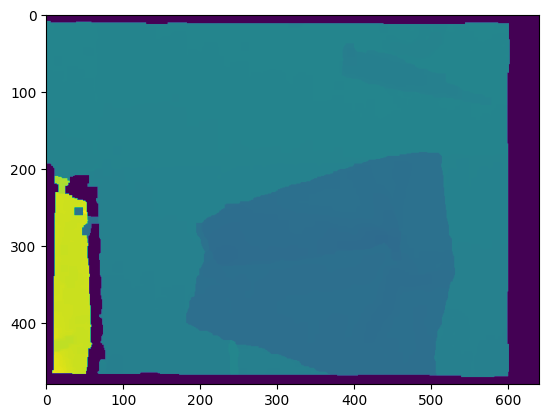

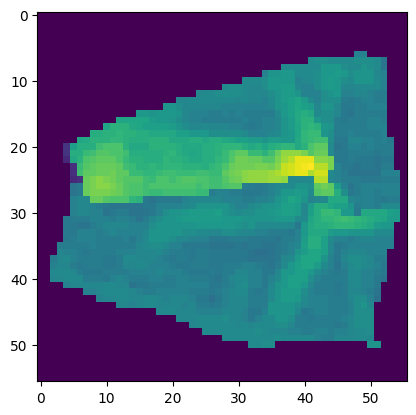

In [33]:
# testing the experiment code: 
model_path = '../model/DDPM_32_64_128_100_iters_120000_wnoise_epoch_2000_newest.ckpt'
ori_path = '../data/state_dict.npy'

real_path = './data_real'

test_ind = 5

EP = Experiment(model_path, ori_path)
rgb, ori_mask, depth_test, corner_pts, processed_pad, ori_pad = load_and_process_real(real_path, ind=test_ind)

depth_img = np.zeros((3, 56, 56)) 
depth_img[0, :, :] = depth_test
depth_img[1, :, :] = depth_test
depth_img[2, :, :] = depth_test
pred_img = EP.run_Diffusion_single(depth_img, img_w=40, img_h=40, num_iter = 10, num_diffusion_iters=100)

[[ 9.99889987e-01  1.48328892e-02  0.00000000e+00 -1.66355192e+01]
 [-1.48328892e-02  9.99889987e-01  0.00000000e+00 -2.29626546e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]


PointCloud with 625 points.

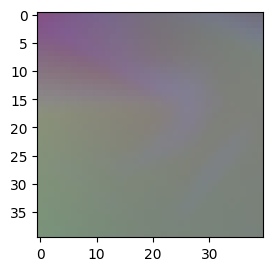

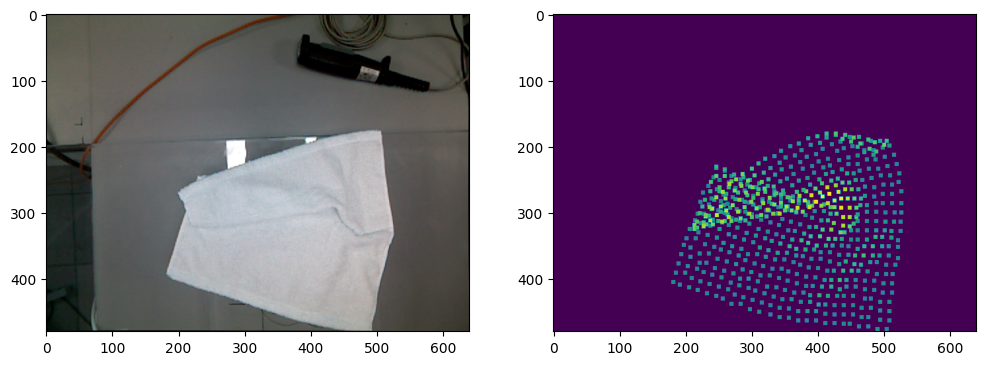

In [34]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(pred_img)

pred_pts = EP.rev_prediction(pred_img)
depth_pts, depth_shift, depth_scale = depth_to_pts(depth_test, depth_test>0)

normed_pred_pts, _, _ = std_scale_pts(pred_pts)
_, normed_depth_mean, normed_depth_std = std_scale_pts(depth_pts)

pred_pts_normed_depth_coord = normed_depth_std*normed_pred_pts+normed_depth_mean
pred_pts_depth_coord = pts_to_depth_coord(pred_pts_normed_depth_coord, depth_shift, depth_scale)
pred_pts_ori_coord = reverse_process_real(pred_pts_depth_coord, corner_pts, processed_pad, ori_pad, depth_test.shape)

pred_pts_ori_coord = final_align(ori_mask, pred_pts_ori_coord)

reversed_depth_img = np.zeros((480, 640))
for i in range(pred_pts_ori_coord.shape[0]):
    reversed_depth_img[int(pred_pts_ori_coord[i,0])-3: int(pred_pts_ori_coord[i,0])+3, \
    int(pred_pts_ori_coord[i,1])-3: int(pred_pts_ori_coord[i,1]) +3] = pred_pts_ori_coord[i,2]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(121)
ax.imshow(rgb)
# ax.set_title('Ground Truth (RGB)')
ax = fig.add_subplot(122)
ax.imshow(reversed_depth_img)
# ax.set_title('Estimated Cloth')
plt.savefig(os.path.join(real_path,str(test_ind)))

pred_pc = o3d.geometry.PointCloud()
pred_pc.points = o3d.utility.Vector3dVector(pred_pts) 
pred_pc.paint_uniform_color([1, 0, 0])


In [35]:
# display mesh: 
mesh = trimesh.Trimesh(vertices=pred_pts, faces=blanket_faces(True))
print(mesh)
mesh.show()

<trimesh.Trimesh(vertices.shape=(625, 3), faces.shape=(2304, 3))>
